# **Computer Vision - Image Captioning**

Image captioning is the task of predicting a caption for a given image. Common real world applications of it include aiding visually impaired people that can help them navigate through different situations. Therefore, image captioning helps to improve content accessibility for people by describing images to them.

This project will use fine-tuning on an already pretrained Hugging Face  model: [Salesforce/blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) for Fashion Items Captioning. 

The model uses both Natural Language Processing and Computer Vision techniques to generate captions for images. This model utilizes NLP to understand and process the textual context of the image, enabling it to generate coherent and contextually relevant captions. Additionally, it leverages CV to analyze the visual content of the image, extracting meaningful features and incorporating visual information into the caption generation process. By integrating both NLP and CV, the model can produce captions that capture both the visual and semantic aspects of the image.

An example of what we're trying to achieve looks like this: 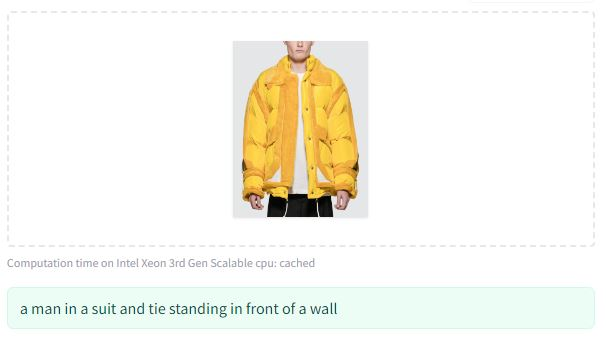

Let's hope our fine tuned version is a little more accurate! ✔



## 1.1. Installs & Connecting to 🤗

In [1]:
!pip install transformers==4.28.0 -q datasets rouge sacrebleu
!git config --global credential.helper store
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.3 MB/s eta 0:00:00

    _|    _|  _|    _|    _|_|_|

## 1.2. Imports

In [2]:
import random
import numpy as np
import pandas as pd
from sacrebleu.metrics import BLEU, CHRF
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, BlipForConditionalGeneration, pipeline
from datasets import load_dataset, Dataset
from PIL import Image
import base64
import os
import io
os.environ["WANDB_DISABLED"] = "true"

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import matplotlib for visualization
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode

# Measure time
from timeit import default_timer as timer

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldnt' be lower than 0.11
print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')


PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


## 2. Loading data

For this project, I'm going to be using a pre-processed Fashion Items dataset.
Original dataset can be found [here](https://huggingface.co/datasets/ashraq/fashion-product-images-small).

For the image captioning task, I am going to focus on the 'text' of the fashion item a.k.a. the descriptions that we want to train the model on. Let's inspect closer.

In [3]:
dataset = load_dataset("agestau/preproc-fashion-products")
ds=dataset["train"]
dataset7 = ds.remove_columns(['subCategory'])
dataset7

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/36145 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/agestau___parquet/agestau--preproc-fashion-products-fe572d0abe1a2515/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 36145
})

An example of a random record from the dataset:

In [5]:
def random_image(dataset):
    example_index = random.randint(0, len(dataset["train"]) - 1)
    example = dataset["train"][example_index]
    label, img, text = example["subCategory"], example["image"], example["text"]
    return example_index, label, img, text

random_image(dataset)

(29971,
 'Bags',
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7FF619B8ACE0>,
 'Nike Unisex Medium Blue Backpack')

Let's see how the values look like:

In [6]:
dataset7[29971]["text"]

'Nike Unisex Medium Blue Backpack'

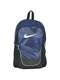

In [7]:
dataset7[29971]["image"]

## 3. Preparing data for training

To fine tune this model, we'll be using Pytorch. As the data right now is a Hugging Face dataset, first we'll need to convert it into a Pytorch one.

Next step will be to write functions for train, text and evaluation steps. 

Ater that, we will be able to train the model.

Splitting the data in to train and test samples:

In [9]:
dataset7 = dataset7.train_test_split(test_size=0.1)
train_ds = dataset7["train"]
test_ds = dataset7["test"]

Function to create a Pytorch dataset:

In [10]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

Let's load processor (this is also a tokenizer) and the model from the hub:

In [51]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

We select `device = "cuda"` as to train an image captioning model requires a lot of memory, we have to do it on a GPU.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Create Pytorch datasets and data loaders to help with training/testing/evaluating in batches.

In [13]:
train_dataset = ImageCaptioningDataset(train_ds, processor)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = ImageCaptioningDataset(test_ds, processor)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [14]:
sample_batch = next(iter(train_dataloader))
print(sample_batch)

{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

From the exmple above, we can see that our picture, that was in PIL format, has now been converted to a tensor.

## 4. Functions for training

Function to time the modelling process

In [52]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

Function for training the model

In [53]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()

    for idx, batch in enumerate(data_loader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # 1. Forward pass
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        loss = outputs.loss
        train_loss += loss.item()

        # 2. Optimizer zero grad
        optimizer.zero_grad()

        # 3. Loss backward
        loss.backward()

        # 4. Optimizer step
        optimizer.step()

        # Print loss per batch
        if (idx + 1) % 10 == 0:
          print(f"Batch {idx+1}/{len(data_loader)} - Loss: {loss:.5f}")

    # Calculate loss per epoch and print out
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")
    

Function for testing the model

In [54]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              device: torch.device = device):
    test_loss = 0
    model.eval()  # Put model in evaluation mode

    with torch.inference_mode():
        for idx, batch in enumerate(data_loader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            # 1. Forward pass
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            loss = outputs.loss
            test_loss += loss.item()

        # Calculate loss per epoch and print out
        test_loss /= len(data_loader)
        print(f"Test loss: {test_loss:.5f}\n")

Function for evaluating the model (1) - using model.eval()

In [58]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
  
    import logging
    import warnings
    logging.getLogger("transformers").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore")

    bleu = BLEU()
    chrf = CHRF()

    model = model.to(device)
    model.eval()
    predictions = []
    references = []

    with torch.inference_mode():
        for idx, batch in enumerate(data_loader, start=1):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model.generate(input_ids=input_ids,pixel_values=pixel_values,max_length=50)
            
            predicted_sentences_batch = processor.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(predicted_sentences_batch)
            
            reference_sentences_batch = [processor.decode(ids, skip_special_tokens=True) for ids in input_ids]
            references.extend(reference_sentences_batch)

            # Prints individual batch results for the batch
            if idx % 500 == 0:
                print(f"Batch {idx}:")
                print("predicted_sentences:")
                print(predicted_sentences_batch)
                print("reference_sentences:")
                print(reference_sentences_batch)
                print(type(reference_sentences_batch))
                print()

                # BLEU and CHRF scores for the current batch
                bleu_score = bleu.corpus_score(predicted_sentences_batch, [reference_sentences_batch])
                print(f"BLEU score for Batch {idx}: {bleu_score.score}")

                chrf_score = chrf.corpus_score(predicted_sentences_batch, [reference_sentences_batch])
                print(f"CHRF score for Batch {idx}: {chrf_score.score}")
                print()  # Print an empty line for readability
        
    return {"model_name": "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
            "bleu_score": bleu.corpus_score(predictions, [references]).score,
            "chrf_score": chrf.corpus_score(predictions, [references]).score}

Function for evaluating the model (2) - using the model for inference

In [56]:
def evaluate_model(model, data, device):
    model = model.to(device)
    predictions = []
    references = []

    for i, example in enumerate(data):
        image = example["image"]
        real_caption = example["text"]
        references.append(real_caption.lower())

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(" ".join(generated_caption.split()))

    print("reference_sentences:")
    print(references)
    print("predicted_sentences:")
    print(predictions)
    print()

    print("bleu_score: ", BLEU().corpus_score(predictions, [references]).score)
    print("chrf_score: ", CHRF().corpus_score(predictions, [references]).score)

## 5. Training

In [ ]:
torch.manual_seed(42)

# Measure time
train_time_start = timer()

model.to(device)

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    #sample_data = next(iter(test_dataloader))
    #print(sample_data) 
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model, 
          data_loader=train_dataloader,
          optimizer=optimizer,
          device=device
    )
    test_step(model=model,
         data_loader=test_dataloader,
         device=device
    )

train_time_end = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start, 
                                              end=train_time_end,
                                              device=device)


Using this training loop, I fine-tuned 3 models:
*   `f_cap_100recs` -- a random sample of a 100 recs in total - 90 training; 10 validation; 10 Epochs. Results for the model looked like this:
> Train loss: 1.36125; 
> Test loss: 1.38747; 
> Train time on cuda: 110.131 seconds;

*   `f_cap_1000recs` -- a random sample of a 1,000 recs - 900 training; 100 validation; batch_size=5; 5 Epochs. Results for the model looked like this:
> Train loss: 1.36745; 
> Test loss: 1.38570; 
> Train time on cuda: 426.320 seconds

*   `f_cap_allrecs` -- the whole dataset - 32,530 training; 3,615 validation; batch_size=5; 3 Epochs. Results for the model looked like this:
> Train loss: 1.37130; 
> Test loss: 1.37355; 
> Train time on cuda: 9206.441 seconds

All models were puched to the Hugging Face hub just like this:

In [ ]:
model.push_to_hub("f_cap_100recs") 
model.push_to_hub("f_cap_1000recs") 
model.push_to_hub("f_cap_allrecs") 

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/agestau/f_cap_allrecs/commit/381cc5193e527833ca89447a86a1f2aa817d87da', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='381cc5193e527833ca89447a86a1f2aa817d87da', pr_url=None, pr_revision=None, pr_num=None)

## 6. Evaluating the model

Let's first load the models from the hub:

In [18]:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model_ft_100recs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_100recs")
model_ft_1000recs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_1000recs")
model_ft_allrecs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_allrecs")

Let's try the models on 6 random samples from the dataset:

In [70]:
def plot_generated_captions(model):
    fig = plt.figure(figsize=(12, 8))

    # Convert dataset7 to a list and select 6 random examples
    random_examples = random.sample(list(dataset7["train"]), 6)

    # Prepare and plot the selected examples
    for i, example in enumerate(random_examples):
        image = example["image"]
        real_caption = example["text"]

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model_ft_100recs.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        ax = fig.add_subplot(2, 3, i+1)
        ax.imshow(image)
        ax.axis("off")
        ax.text(0, -20, f"Real caption: {real_caption}", fontsize=10, ha="left")
        ax.text(0, -40, f"Generated caption: {generated_caption}", fontsize=10, ha="left")

    plt.tight_layout()
    plt.show()


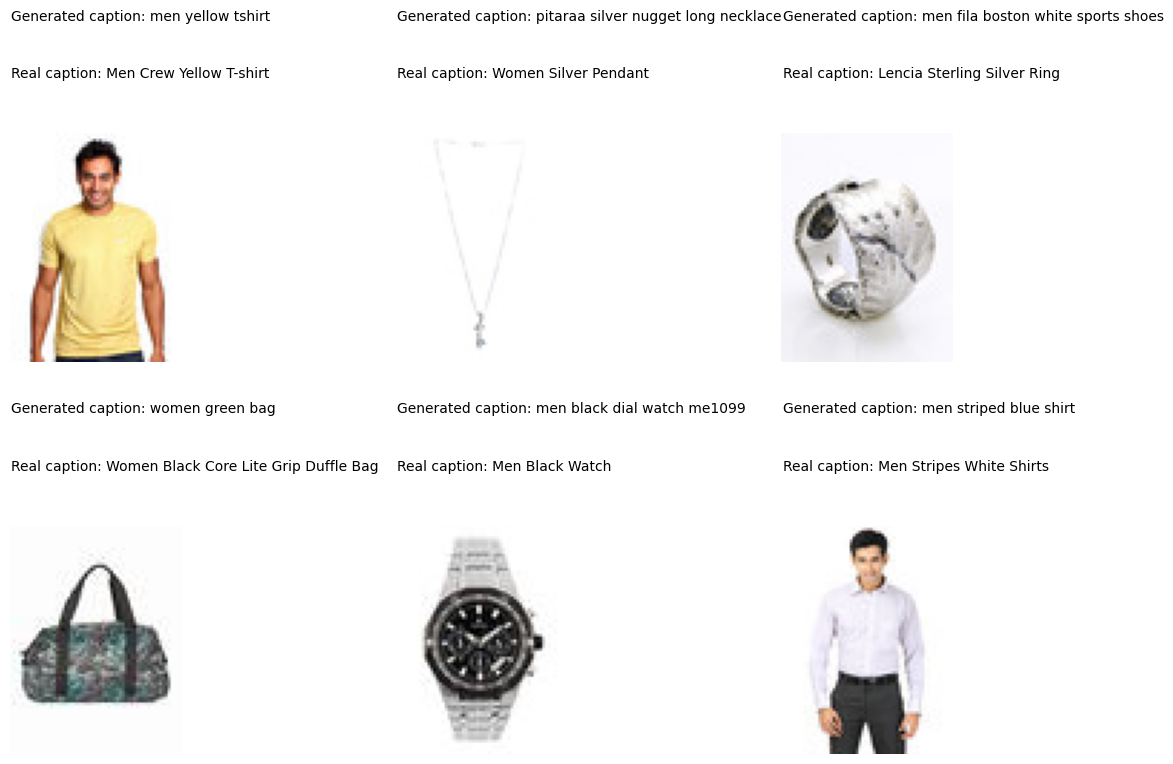

In [71]:
plot_generated_captions(model)

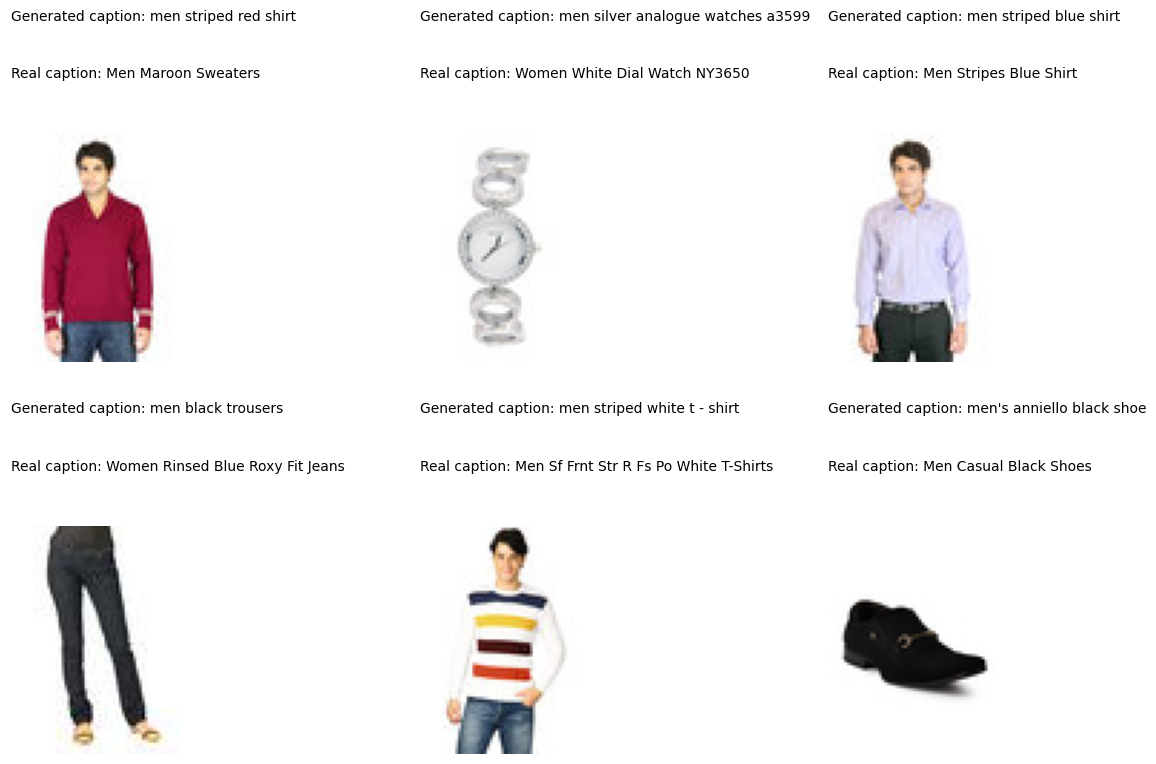

In [76]:
plot_generated_captions(model_ft_100recs)

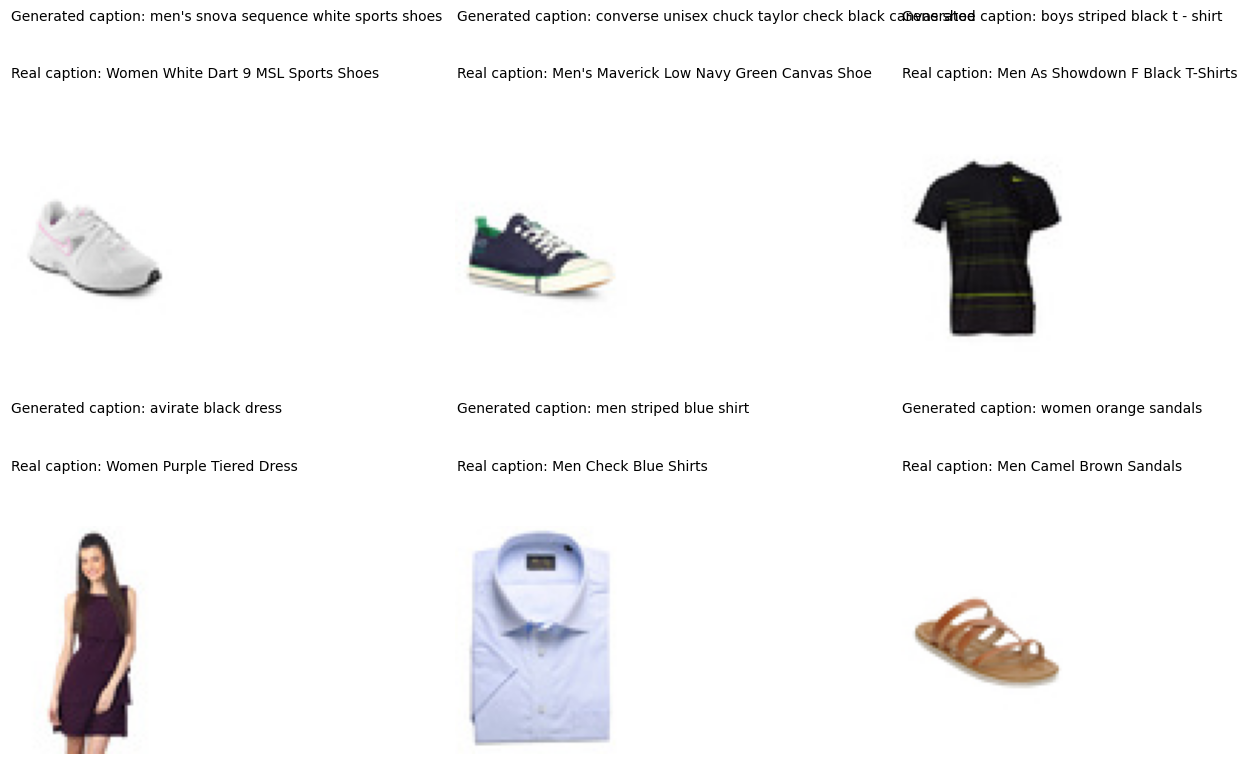

In [77]:
plot_generated_captions(model_ft_1000recs)

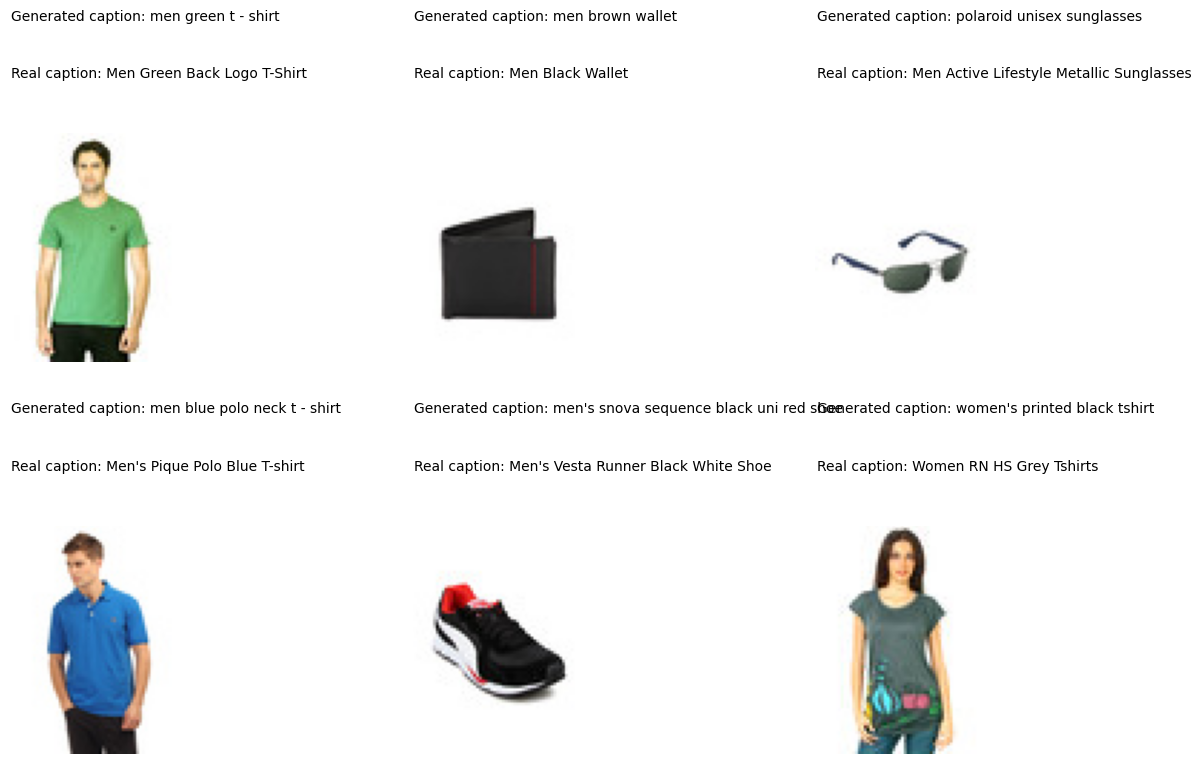

In [78]:
plot_generated_captions(model_ft_allrecs)

Just looking though these manually, it seems like the model `model_ft_allrecs` captions the best.

Let's evaluate using model.eval():

In [59]:
eval_model(model=model,data_loader=test_dataloader) 

Batch 500:
predicted_sentences:
['men summers brown sandalss', 'men ufficio black walleter', 'men white shoess', 'men black formal shoess', 'men orange printed t - shirter']
reference_sentences:
['men summers brown sandals', 'men ufficio black wallet', 'men white shoes', 'men black formal shoes', 'men orange printed t - shirt']
<class 'list'>

BLEU score for Batch 500: 55.55238068023583
CHRF score for Batch 500: 98.37411105068733



{'model_name': "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
 'bleu_score': 79.26982922945986,
 'chrf_score': 99.2129289968868}

In [60]:
eval_model(model=model_ft_100recs,data_loader=test_dataloader) 

Batch 500:
predicted_sentences:
['men panel polo blue t - shirt', 'men black dial watch', 'men europa casual shoes', 'men check ladislav purple shirts', "men's placid blue t - shirt"]
reference_sentences:
['men panel polo blue t - shirt', 'men black dial watch', 'men europa casual shoes', 'men check ladislav purple shirts', "men's placid blue t - shirt"]
<class 'list'>

BLEU score for Batch 500: 100.00000000000004
CHRF score for Batch 500: 100.0



{'model_name': "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
 'bleu_score': 100.00000000000004,
 'chrf_score': 100.0}

In [61]:
eval_model(model=model_ft_1000recs,data_loader=test_dataloader) 

Batch 500:
predicted_sentences:
['men brown leather semiformal shoes', 'women white silicon strap stones watch', 'men blue sweaters', 'men adna 3s shrt kn grey shorts', "men's round neck white t - shirt"]
reference_sentences:
['men brown leather semiformal shoes', 'women white silicon strap stones watch', 'men blue sweaters', 'men adna 3s shrt kn grey shorts', "men's round neck white t - shirt"]
<class 'list'>

BLEU score for Batch 500: 100.00000000000004
CHRF score for Batch 500: 100.0



{'model_name': "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
 'bleu_score': 99.98922957043011,
 'chrf_score': 99.99894400254526}

In [62]:
eval_model(model=model_ft_allrecs,data_loader=test_dataloader) 

Batch 500:
predicted_sentences:
['boys check blue shirts', 'men running white sports shoes', 'women casual black sandal', 'men yellow printed t - shirt', 'women brown with stitch bag']
reference_sentences:
['boys check blue shirts', 'men running white sports shoes', 'women casual black sandal', 'men yellow printed t - shirt', 'women brown with stitch bag']
<class 'list'>

BLEU score for Batch 500: 100.00000000000004
CHRF score for Batch 500: 100.0



{'model_name': "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
 'bleu_score': 100.00000000000004,
 'chrf_score': 100.0}

These results do not seem to make much sense. BLEU score cannot be equal or close to 100 for any of these models (based on the examples we saw above).

Let's try to calculate BLEU score with model.generate():

In [63]:
random_examples = random.sample(list(test_ds), 100)

In [64]:
evaluate_model(model, random_examples, device)

reference_sentences:
['men white t-shirt', 'men orange printed t-shirt', 'men blue shirt', 'men blue tie', 'men white elite speed sports shoes', 'men black jacket', 'men printed navy blue tshirts', "men's tank respi black t-shirt", 'artengo artengo 633d man black', 'women grey & peach sandals', 'men sheet sunglasses', 'men purple polo t-shirt', 'men adipure trainer black sports shoes', 'men navy blue socks', 'men clipper black shoes', 'girls pink flip flops', 'men asem cricket crazy blue t-shirts', 'men blue millard jeans', 'doodle boy mummy daddy me yellow tshirts', 'women black dial watch', 'women red dress', 'men white dial watch', 'men formal black formal shoes', 'women navy trouser', 'men black dial watch', 'men washed blue jeans', 'women printed purple t-shirt', 'women sparkling coral red necklace', "men's ganesha red black t-shirt", 'women orange & white bags', 'men soft check shirt', "men's lunarfly blue shoe", 'women free white pink shoe', 'boys boys blue washed jeans', 'men b

In [65]:
evaluate_model(model_ft_100recs, random_examples, device)

reference_sentences:
['men white t-shirt', 'men orange printed t-shirt', 'men blue shirt', 'men blue tie', 'men white elite speed sports shoes', 'men black jacket', 'men printed navy blue tshirts', "men's tank respi black t-shirt", 'artengo artengo 633d man black', 'women grey & peach sandals', 'men sheet sunglasses', 'men purple polo t-shirt', 'men adipure trainer black sports shoes', 'men navy blue socks', 'men clipper black shoes', 'girls pink flip flops', 'men asem cricket crazy blue t-shirts', 'men blue millard jeans', 'doodle boy mummy daddy me yellow tshirts', 'women black dial watch', 'women red dress', 'men white dial watch', 'men formal black formal shoes', 'women navy trouser', 'men black dial watch', 'men washed blue jeans', 'women printed purple t-shirt', 'women sparkling coral red necklace', "men's ganesha red black t-shirt", 'women orange & white bags', 'men soft check shirt', "men's lunarfly blue shoe", 'women free white pink shoe', 'boys boys blue washed jeans', 'men b

In [66]:
evaluate_model(model_ft_1000recs, random_examples, device)

reference_sentences:
['men white t-shirt', 'men orange printed t-shirt', 'men blue shirt', 'men blue tie', 'men white elite speed sports shoes', 'men black jacket', 'men printed navy blue tshirts', "men's tank respi black t-shirt", 'artengo artengo 633d man black', 'women grey & peach sandals', 'men sheet sunglasses', 'men purple polo t-shirt', 'men adipure trainer black sports shoes', 'men navy blue socks', 'men clipper black shoes', 'girls pink flip flops', 'men asem cricket crazy blue t-shirts', 'men blue millard jeans', 'doodle boy mummy daddy me yellow tshirts', 'women black dial watch', 'women red dress', 'men white dial watch', 'men formal black formal shoes', 'women navy trouser', 'men black dial watch', 'men washed blue jeans', 'women printed purple t-shirt', 'women sparkling coral red necklace', "men's ganesha red black t-shirt", 'women orange & white bags', 'men soft check shirt', "men's lunarfly blue shoe", 'women free white pink shoe', 'boys boys blue washed jeans', 'men b

In [67]:
evaluate_model(model_ft_allrecs, random_examples, device)

reference_sentences:
['men white t-shirt', 'men orange printed t-shirt', 'men blue shirt', 'men blue tie', 'men white elite speed sports shoes', 'men black jacket', 'men printed navy blue tshirts', "men's tank respi black t-shirt", 'artengo artengo 633d man black', 'women grey & peach sandals', 'men sheet sunglasses', 'men purple polo t-shirt', 'men adipure trainer black sports shoes', 'men navy blue socks', 'men clipper black shoes', 'girls pink flip flops', 'men asem cricket crazy blue t-shirts', 'men blue millard jeans', 'doodle boy mummy daddy me yellow tshirts', 'women black dial watch', 'women red dress', 'men white dial watch', 'men formal black formal shoes', 'women navy trouser', 'men black dial watch', 'men washed blue jeans', 'women printed purple t-shirt', 'women sparkling coral red necklace', "men's ganesha red black t-shirt", 'women orange & white bags', 'men soft check shirt', "men's lunarfly blue shoe", 'women free white pink shoe', 'boys boys blue washed jeans', 'men b

These results make more sense. This also makes it evident, that training on a larger dataset is worth it, even though it takes more time.